# Applicability of the text

This notebook will go over the text with minor changes from `010_exploring_puheenvuoroja.ipynb`. I will make some more changes to the data, i.e. lemmatize it for more smooth analysis, and get an overview on its current properties

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(30,10)

In [2]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///eduskunta.db', echo=False)


In [3]:

pvt_bt = pd.read_sql_table("puheenvuorot_bad_times", con=engine)
pvt_bt.set_index("PvID", inplace=True)  # Puheenvuoro ID – Speech ID
pvt_bt.head(3)

,Käsittelyvaihe,Vireilletuloasiakirja,Järjestys,ID,Asema,Etunimi,Sukunimi,Eduskuntaryhmä,Puheenvuorotyyppi,Aloitusajankohta,Lopetusajankohta,Puheenvuoro,Pöytäkirjan verkko-osoite,EduskuntaryhmäVäri
PvID,,,,,,,,,,,,,,
0,Ainoa käsittely,ETJ 1/2019 vp,1,1092,-,Mika,Niikko,ps,varsinainen puheenvuoro,2019-05-07 14:01:59,2019-05-07 14:06:50,Arvoisa puhemies ja hyvät kollegat! Valtiopäiv...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...,#FFD500
1,Ainoa käsittely,ETJ 1/2019 vp,2,1437,-,Juha,Mäenpää,ps,varsinainen puheenvuoro,2019-05-07 14:06:55,2019-05-07 14:14:11,Arvoisa puhemies! Hyvät kollegat! Meiltä kansa...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...,#FFD500
2,Ainoa käsittely,ETJ 1/2019 vp,3,1275,-,Mika,Raatikainen,ps,varsinainen puheenvuoro,2019-05-07 14:14:16,2019-05-07 14:14:53,Arvoisa rouva puhemies! Tarkoitus oli puhua pe...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...,#FFD500


In [4]:
pvt_bt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36273 entries, 0 to 36272
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Käsittelyvaihe             36273 non-null  object        
 1   Vireilletuloasiakirja      36273 non-null  object        
 2   Järjestys                  36273 non-null  int64         
 3   ID                         36273 non-null  int64         
 4   Asema                      36273 non-null  object        
 5   Etunimi                    36273 non-null  object        
 6   Sukunimi                   36273 non-null  object        
 7   Eduskuntaryhmä             36273 non-null  object        
 8   Puheenvuorotyyppi          36273 non-null  object        
 9   Aloitusajankohta           36273 non-null  datetime64[ns]
 10  Lopetusajankohta           36273 non-null  object        
 11  Puheenvuoro                36273 non-null  object        
 12  Pöyt

In [5]:
party_codes = list(pvt_bt["Eduskuntaryhmä"].unique())

# vas should be "BF1E24" but it's really close to sd, so change it to a darker #5f0f11
color_codes = ["#FFD500", "#E11931", "#5f0f11", "#006288", "#FFDD93", "#01954B", "#2B67C9", "#CCCCCC", "#61BF1A", "#ae2375", "#7475a6", "#000000"]
color_dict = dict(zip(party_codes, color_codes))


## Explorinig the texts of speeches

The goal of this notebook is to uncover which topics the MPs talked about. For this, I did read about `gensim` library, which has tools for topics modelling. However, I wasn't as familiar with the library, and also heard about `sk-learn`'s `TFIDFVectorizer`, and opted to use it, as I knew more about the library in general, while sci-kit has lots of different features in itself.

* The level of granularity for this implementation is the groups. Specific MPs could be investigated, too, but that's gonna be later.
* Some degree of lemmatization / stemming is required. Later, I decide to use `Voikko` library to lemmatize the Finnish words, and will end up concentrating on nouns.

<AxesSubplot:xlabel='Eduskuntaryhmä'>

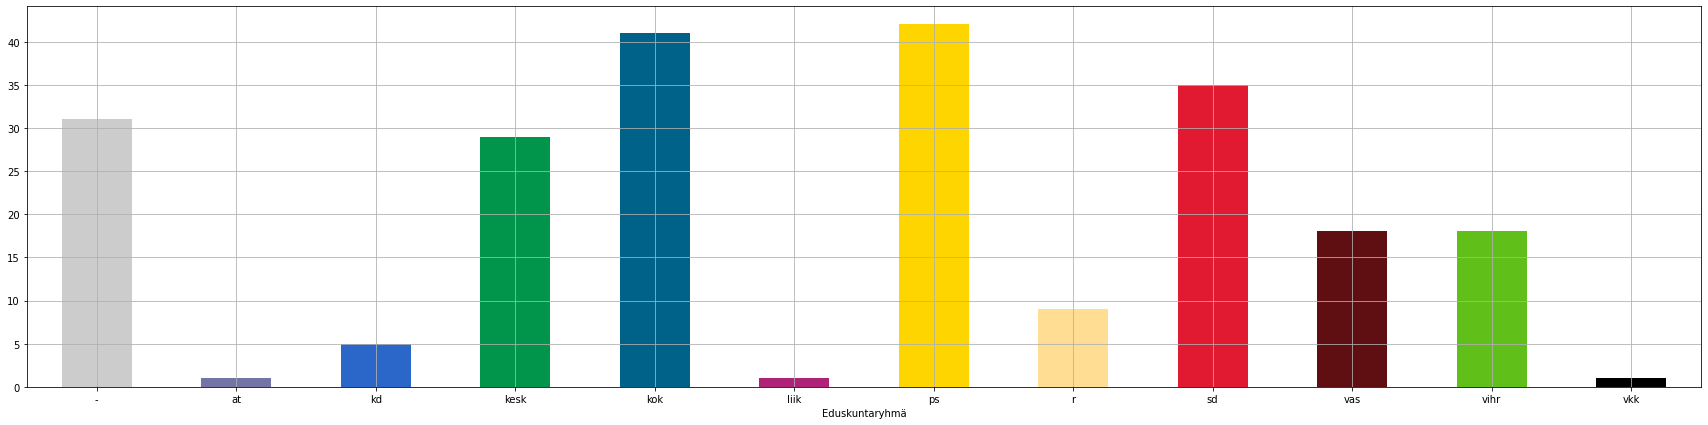

In [6]:
pvt_ryhm = pvt_bt.groupby("Eduskuntaryhmä")
pvt_id = pvt_bt.groupby("ID")

figsize(30,7)

pvt_ryhm_unique_MPs = pvt_ryhm["ID"].nunique()
pvt_ryhm_unique_MPs.plot.bar(rot=0, grid=True, color=[color_dict[col] for col in pvt_ryhm_unique_MPs.index])


### What do they talk about?, attempt 1

One approach is to make long strings which include all speeches of a party. This approach may not be the most efficient computationally but works fine with the current data.

In [7]:
# https://stackoverflow.com/questions/27298178/concatenate-strings-from-several-rows-using-pandas-groupby
puheet = pvt_ryhm["Puheenvuoro"].apply(" ".join)
len(puheet["ps"])  # characters

15156730

A couple of notes:
* Lemmatization / stemming is required to get rid of different inflections of words
  * In this case lemmatization would be more efficient, as the base forms of words are what really matters when using TF-IDF (which will be explained later)
* Some of the most frequent words are the same for many parties

#### Stemming


Stemming (*reducing inflected (or sometimes derived) words to their word stem* [Wikipedia] ) is simpler than lemmatization. It is supported by nltk library, for instance.

In [8]:
from nltk.stem.snowball import SnowballStemmer

stemmer_fi = SnowballStemmer("finnish")

print(stemmer_fi.stem("hallitus"))
print(stemmer_fi.stem("hallituksen"))

hallitus
hallituks


Ok, stemming is a thing, but how about lemmatization?

https://data.solita.fi/finnish-stemming-and-lemmatization-in-python/

Apparently, it is also doable for Finnish using Python. I heard about Voikko earlier but wasn't so sure where to get started with it.

The installation took some extra care, but with the help of

https://voikko.puimula.org/python.html

I managed to get it working!

#### Lemmatization

In essence, lemmatization is *grouping together the inflected forms of a word so they can be analysed as a single item*.  [Wikipedia]

I decided to create a separate column for the lemmatized data. (perhaps the most practical and versatile way). While it takes some more space, the space is not a problem with this amount of data. (talking of megabytes)

In [9]:
#Import the Voikko library
from libvoikko import Voikko

# Unfortunately there are some random languages, too...
stemmer_se = SnowballStemmer("swedish")
stemmer_en = SnowballStemmer("english")

# These two lines were the critical ones ↓
# Define a Voikko class for Finnish
Voikko.setLibrarySearchPath("C:\\Users\\Ari\\anaconda3\\envs\\joda22\\Voikko")
v = Voikko(language=u"fi", path="C:\\Users\\Ari\\anaconda3\\envs\\joda22\\Voikko")

# An example with multiple postpositions(?) / just complex inflection
word = "syntymäpäiväjuhliltanneko"
voikko_dict = v.analyze(word)
word_baseform = voikko_dict[0]['BASEFORM']

print(word_baseform)

syntymäpäiväjuhla


At first, the plan was to create one _long_ string per group, and for that I needed to use textwrap to create batches.

The following `lemmatize_fi_sv_voikka` has a bit of extra stuff that isn't required in the final version

In [10]:
from nltk import word_tokenize
from textwrap import wrap

# Tokenizing will take time. It's ok

def lemmatize_fi_sv_voikko(text):
    #tokens = [word for word in word_tokenize(text)]
    #print("Tokenizing 'text'")
    # Too long strings --> word_tokenize wasn't somehow sufficient
    # This isn't an optimal solution, but textwrap can be used to divide text into chunks manageable by word_tokenize
    # Then, the token lists can be extended into a bigger list!
    
    #print("Start wrapping")
    wrapped_text = wrap(text, width=500000)  # 500k went well in debug
    tokens = []
    #print("Start going over wrapping stuff")
    for batch in wrapped_text:
        tokenized_batch = word_tokenize(batch)
        tokens.extend(tokenized_batch)
    
    #print("Done with wrapping")

    # This would work if voikko could analyze also non-finnish words
    # lemmatized = [v.analyze(item)[0]["BASEFORM"] for item in tokens]
    
    lemmatized_list = []
    for token in tokens:
        try:
            lemmatized_word = v.analyze(token)[0]["BASEFORM"]
        except IndexError:  # If non-finnish word is encountered
            # Expect it to be swedish & stem it instead (sorry swedes)
            # TODO create an instance of Voikko for swedish (requires a swedish dictionary generated by voikko)
            # voikko-build-dicts / https://www.puimula.org/htp/testing/voikko-snapshot-v5/
            lemmatized_word = stemmer_se.stem(token)
        lemmatized_list.append(lemmatized_word)
    #print("Lemmatization finished")
    return lemmatized_list

words = "hauskoja suomenkielisiä sanoja, joita on taivuteltukin!"
lemmatize_fi_sv_voikko(words)


['hauska', 'suomenkielinen', 'sanoja', ',', 'joka', 'olla', 'taivuteltu', '!']

The following function, while it isn't considerably faster, is far simpler & cleaner, and works with the latest implementation.

Here, accessing the Voikko dictionary separately for every word may not be the most efficient way, yet, this version is pretty much as minimalistic as I could create without extra tinkering with Voikko.

In [11]:
def lemmatize_fi_sv_voikko_fast(text:str):
    tokens = [word for word in word_tokenize(text)]

    def lemmatize_token(tok):
        try:
            return v.analyze(tok)[0]["BASEFORM"]
        
        except IndexError:  # Gets triggered when the word isn't in Voikko's Finnish dictionary (i.e. the word is Swedish)
            return stemmer_se.stem(tok)
    
    lemmatized_list = map(lambda elem: lemmatize_token(elem), tokens)
    
    return list(lemmatized_list)
    

In [12]:
pvt_bt["Puheenvuoro"]

PvID
0        Arvoisa puhemies ja hyvät kollegat! Valtiopäiv...
1        Arvoisa puhemies! Hyvät kollegat! Meiltä kansa...
2        Arvoisa rouva puhemies! Tarkoitus oli puhua pe...
3        Rouva puhemies! Eduskunnan arvovallalle ei ole...
4        Arvoisa puhemies! Aivan ensimmäisenä kannatan ...
                               ...                        
36268    Arvoisa herra puhemies! Teen perustuslain 73 §...
36269    Arvoisa puhemies! Kannatan edustaja Karin teke...
36270    Arvoisa puhemies! Kiireelliseksijulistamismene...
36271    Kiitos, arvoisa puhemies! Teen tässä vaiheessa...
36272    Arvoisa puhemies! Kannatan edustaja Peltokanka...
Name: Puheenvuoro, Length: 36273, dtype: object

In [13]:
# Create a new column of lemmatized data for each speech. 
# This data is in lists of tokens, i.e. ["baseform_1st_word", "baseform_2nd_word", ...]
pvt_bt["Puheenvuoro Lem"] = pvt_bt.apply(lambda row: lemmatize_fi_sv_voikko_fast(row["Puheenvuoro"]), axis=1)

In [14]:
pvt_bt["Puheenvuoro Lem"]

PvID
0        [arvoisa, puhemies, ja, hyvä, kollega, !, valt...
1        [arvoisa, puhemies, !, hyvä, kollega, !, me, k...
2        [arvoisa, rouva, puhemies, !, tarkoitus, olla,...
3        [rouva, puhemies, !, eduskunta, arvovalta, ei,...
4        [arvoisa, puhemies, !, aivan, ensimmäinen, kan...
                               ...                        
36268    [arvoisa, herra, puhemies, !, tehdä, perustusl...
36269    [arvoisa, puhemies, !, kannattaa, edustaja, Ka...
36270    [arvoisa, puhemies, !, kiireelliseksijulistami...
36271    [kiitos, ,, arvoisa, puhemies, !, tehdä, tämä,...
36272    [arvoisa, puhemies, !, kannattaa, edustaja, pe...
Name: Puheenvuoro Lem, Length: 36273, dtype: object

In [15]:
pvt_bt["Puheenvuoro Lem"] = pvt_bt["Puheenvuoro Lem"].apply(lambda lst: ' '.join(lst))

### Lemmatized versions for groups

#### Group by (MP) Group

Create a lemmatized version for each of 12 groups present

In [16]:
# Lemmatized version for every group
pvt_ryhm_lem = pvt_ryhm["Puheenvuoro Lem"].apply(lambda group: ''.join(group.sum()))


In [17]:
pvt_ryhm_lem.head()

Eduskuntaryhmä
-       arvoisa puhemies ! esitys ehdottaa muutettava ...
at      arvoisa rouva puhemies ! perustuslaki pykälä k...
kd      arvoisa puhemies ! käsiteltävä olla siis valti...
kesk    arvoisa rouva puhemies ! ei tämä olla kyse kuu...
kok     arvoisa rouva puhemies ! arvoisa Suomi kansa e...
Name: Puheenvuoro Lem, dtype: object

In [18]:
print(type(pvt_ryhm_lem))
print(type(pvt_ryhm_lem[0]))

<class 'pandas.core.series.Series'>
<class 'str'>


#### Group by individual MP

Create a lemmatized version for each of 212 MPs present

In [19]:
pvt_id_lem = pvt_id["Puheenvuoro Lem"].apply(lambda group: ''.join(group.sum()))

In [20]:
pvt_id_lem.head()

ID
116    arvoisa puhemies ! tämä olla erityinen edustaj...
118    arvoisa puhemies ! edustaja Kanerva aikaisemmi...
170    arvoisa puheenjohtaja ! olla aika moni asia py...
175    arvoisa herra puhemies ! olla tosi syyttää ant...
301    arvoisa rouva puhemies ! arvoisa Suomi kansa e...
Name: Puheenvuoro Lem, dtype: object

### Option to exclude interjections

In [21]:
pvt_ryhm_lem.iloc[2][1200:1500]

'puoli erilainen edunvalvonta- ja lobbaustaho [ Ben zyskowicz : Antti rinne lobbarihallitus syntymä ! ] ja myös vaalirahoittaja , kuten eräs ammattiliitto , esimerkki SAK , jhl , Akava . mediatieto mukaan aina vaikuttajaviestintätoimisto miltton network ja rud peders olla vahva läsnä säätytalo pöytä '

As displayed above, there are still sections with all sorts of interjections. For the sake of future option, let's create a new column which has the parts in `[square brackets]` removed from the strings.

This can be done using regular expressions:

#### Deleting interjections & Demonstration

The following function does the deletion:

In [22]:
import re

example_str_in = pvt_ryhm_lem.iloc[2][1200:1500]

print(example_str_in, "\nCharacters: ", len(example_str_in))
print("\n")

def get_rid_of_interjections(input_string:str, example_prints=False):
    
    # First, process the 
    str_out = re.sub(r'\[.*?\]', '', input_string)
    
    if example_prints:
        print(str_out, "\nCharacters: ", len(str_out))
        print("\n")
    
    str_out = re.sub(r'\s+', ' ', str_out)
    if example_prints:
        print(str_out, "\nCharacters: ", len(str_out))
        
    return str_out


# Demonstration
get_rid_of_interjections(example_str_in, example_prints=True)

# note the extra space between "lobbaustaho  ja myös" disappearing after the second regex

puoli erilainen edunvalvonta- ja lobbaustaho [ Ben zyskowicz : Antti rinne lobbarihallitus syntymä ! ] ja myös vaalirahoittaja , kuten eräs ammattiliitto , esimerkki SAK , jhl , Akava . mediatieto mukaan aina vaikuttajaviestintätoimisto miltton network ja rud peders olla vahva läsnä säätytalo pöytä  
Characters:  300


puoli erilainen edunvalvonta- ja lobbaustaho  ja myös vaalirahoittaja , kuten eräs ammattiliitto , esimerkki SAK , jhl , Akava . mediatieto mukaan aina vaikuttajaviestintätoimisto miltton network ja rud peders olla vahva läsnä säätytalo pöytä  
Characters:  243


puoli erilainen edunvalvonta- ja lobbaustaho ja myös vaalirahoittaja , kuten eräs ammattiliitto , esimerkki SAK , jhl , Akava . mediatieto mukaan aina vaikuttajaviestintätoimisto miltton network ja rud peders olla vahva läsnä säätytalo pöytä  
Characters:  242


'puoli erilainen edunvalvonta- ja lobbaustaho ja myös vaalirahoittaja , kuten eräs ammattiliitto , esimerkki SAK , jhl , Akava . mediatieto mukaan aina vaikuttajaviestintätoimisto miltton network ja rud peders olla vahva läsnä säätytalo pöytä '

#### Original with additional col for lemmatizations

In [23]:
pvt_bt['Puheenvuoro Lem ilman keskeytyksiä'] = pvt_bt["Puheenvuoro Lem"].apply(lambda row_value: get_rid_of_interjections(row_value))

#### Group by (MP) Group


In [24]:
pvt_ryhm_lem_no_interjections = pvt_ryhm_lem.apply(lambda row_value: get_rid_of_interjections(row_value))


In [25]:
pvt_ryhm_lem_no_interjections.name = 'Puheenvuoro Lem ilman keskeytyksiä'
pvt_ryhm_lem_no_interjections

Eduskuntaryhmä
-       arvoisa puhemies ! esitys ehdottaa muutettava ...
at      arvoisa rouva puhemies ! perustuslaki pykälä k...
kd      arvoisa puhemies ! käsiteltävä olla siis valti...
kesk    arvoisa rouva puhemies ! ei tämä olla kyse kuu...
kok     arvoisa rouva puhemies ! arvoisa Suomi kansa e...
liik    arvoisa puhemies ! epäillä Suomi jääkiekkomaaj...
ps      arvoisa puhemies ja hyvä kollega ! valtiopäivä...
r       värder fru talman , arvoisa rouva puhemies ! t...
sd      arvoisa puhemies ! haluta ensi todeta , että t...
vas     arvoisa rouva puhemies ! jokainen istuntokausi...
vihr    arvoisa puhemies ! tämä nyt keskustella rinne ...
vkk     arvoisa puhemies ! me kaikki ylin laki olla pe...
Name: Puheenvuoro Lem ilman keskeytyksiä, dtype: object

In [26]:
pvt_ryhm_lem_both = pd.DataFrame([pvt_ryhm_lem, pvt_ryhm_lem_no_interjections]).T
pvt_ryhm_lem_both

,Puheenvuoro Lem,Puheenvuoro Lem ilman keskeytyksiä
Eduskuntaryhmä,,
-,arvoisa puhemies ! esitys ehdottaa muutettava ...,arvoisa puhemies ! esitys ehdottaa muutettava ...
at,arvoisa rouva puhemies ! perustuslaki pykälä k...,arvoisa rouva puhemies ! perustuslaki pykälä k...
kd,arvoisa puhemies ! käsiteltävä olla siis valti...,arvoisa puhemies ! käsiteltävä olla siis valti...
kesk,arvoisa rouva puhemies ! ei tämä olla kyse kuu...,arvoisa rouva puhemies ! ei tämä olla kyse kuu...
kok,arvoisa rouva puhemies ! arvoisa Suomi kansa e...,arvoisa rouva puhemies ! arvoisa Suomi kansa e...
liik,arvoisa puhemies ! epäillä Suomi jääkiekkomaaj...,arvoisa puhemies ! epäillä Suomi jääkiekkomaaj...
ps,arvoisa puhemies ja hyvä kollega ! valtiopäivä...,arvoisa puhemies ja hyvä kollega ! valtiopäivä...
r,"värder fru talman , arvoisa rouva puhemies ! t...","värder fru talman , arvoisa rouva puhemies ! t..."
sd,"arvoisa puhemies ! haluta ensi todeta , että t...","arvoisa puhemies ! haluta ensi todeta , että t..."


#### Group by individual MP

In [27]:
pvt_id_lem_no_interjections = pvt_id_lem.apply(lambda row_value: get_rid_of_interjections(row_value))

# Rename
pvt_id_lem_no_interjections.name = 'Puheenvuoro Lem ilman keskeytyksiä'


In [28]:
pvt_id_lem_both = pd.DataFrame([pvt_id_lem, pvt_id_lem_no_interjections]).T
pvt_id_lem_both

,Puheenvuoro Lem,Puheenvuoro Lem ilman keskeytyksiä
ID,,
116,arvoisa puhemies ! tämä olla erityinen edustaj...,arvoisa puhemies ! tämä olla erityinen edustaj...
118,arvoisa puhemies ! edustaja Kanerva aikaisemmi...,arvoisa puhemies ! edustaja Kanerva aikaisemmi...
170,arvoisa puheenjohtaja ! olla aika moni asia py...,arvoisa puheenjohtaja ! olla aika moni asia py...
175,arvoisa herra puhemies ! olla tosi syyttää ant...,arvoisa herra puhemies ! olla tosi syyttää ant...
301,arvoisa rouva puhemies ! arvoisa Suomi kansa e...,arvoisa rouva puhemies ! arvoisa Suomi kansa e...
...,...,...
1469,[ arvoisa puhemies ! käsitellä nyt ensi vuosi ...,luotonantaja näkökulma velkaantunut ihminen n...
1479,arvoisa puhemies ! oikeudenmukainen yhteiskunt...,arvoisa puhemies ! oikeudenmukainen yhteiskunt...
1480,arvoisa herra puhemies ! ministeri ! olla haus...,arvoisa herra puhemies ! ministeri ! olla haus...


E.g. here the function can be seen in action

### Pushing Lemmatizations to the SQL

#### Original with additional col for lemmatizations

In [29]:
pvt_bt.to_sql("puheenvuorot_bad_times_pvt_lem", con=engine,
           if_exists="replace")  # NOTE this replaces the existing one every time the file is run!

36273

#### Grouped by MP Groups

In [30]:
pvt_ryhm_lem_both.to_sql("puheenvuorot_grouped_by_groups_lem", con=engine,
                  if_exists="replace")  # NOTE this replaces the existing one every time the cell is run!

12

#### Grouped by MPs

In [31]:
pvt_id_lem_both.to_sql("puheenvuorot_grouped_by_ids_lem", con=engine,
                  if_exists="replace")  # NOTE this replaces the existing one every time the cell is run!

212